# Batch effect evaluation on JUMP Target

In [1]:
%load_ext autoreload
%autoreload 2

## Dataset creation

In [2]:
import io
import logging
import os
import os.path as osp
import shutil
import warnings
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import yaml
from lightning import LightningDataModule
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from omegaconf import DictConfig, OmegaConf
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy

import wandb
from src.eval.batch_effect.datamodule import TotalBatchEffectDataModule
from src.eval.batch_effect.evaluator import BatchEffectEvaluator
from src.eval.batch_effect.module import TotalBatchEffectModule
from src.eval.moa.datamodule import JumpMOADataModule
from src.eval.moa.module import JumpMOAImageModule
from src.modules.collate_fn import image_graph_label_collate_function, label_graph_collate_function
from src.modules.compound_transforms import DGLPretrainedFromSmiles
from src.modules.images.timm_pretrained import CNNEncoder
from src.modules.molecules.dgllife_gin import GINPretrainedWithLinearHead
from src.modules.transforms import SimpleTransform
from src.splitters import StratifiedSplitter
from src.utils.io import download_and_extract_zip, load_image_paths_to_array

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [3]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

cpjump1 already mounted.
cpjump2 already mounted.
cpjump3 already mounted.


## First test

In [4]:
metadata_path = "../cpjump1/jump/metadata"
load_data_path = "../cpjump1/jump/load_data"

In [9]:
os.listdir(load_data_path)

['load_data_with_metadata', 'load_data_with_samples', 'final']

In [5]:
os.listdir(metadata_path)

['compound.csv.gz',
 'crispr.csv.gz',
 'microscope_config.csv',
 'microscope_filter.csv',
 'orf.csv.gz',
 'plate.csv.gz',
 'README.md',
 'well.csv.gz',
 'compound.csv',
 'crispr.csv',
 'orf.csv',
 'plate.csv',
 'well.csv',
 'complete_metadata.csv',
 'resolution.csv',
 'JUMP-Target-1_compound_metadata.tsv',
 'JUMP-Target-1_compound_platemap.tsv',
 'JUMP-Target-1_crispr_metadata.tsv',
 'JUMP-Target-1_crispr_platemap.tsv',
 'JUMP-Target-1_orf_metadata.tsv',
 'JUMP-Target-1_orf_platemap.tsv',
 'JUMP-Target-2_compound_metadata.tsv',
 'JUMP-Target-2_compound_platemap.tsv',
 'JUMP-MOA_compound_metadata.tsv',
 'local_metadata.csv']

In [14]:
load_df = pd.read_parquet(osp.join(load_data_path, "final"))

In [15]:
load_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA
0,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
1,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,3,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
2,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A01,6,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
3,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A02,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
4,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,A02,2,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...
...,...,...,...,...,...,...,...,...,...,...
5121195,source_9,20211103-Run16,GR00004421,Z47,3,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121196,source_9,20211103-Run16,GR00004421,Z47,4,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121197,source_9,20211103-Run16,GR00004421,Z48,1,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...
5121198,source_9,20211103-Run16,GR00004421,Z48,2,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...


In [6]:
meta = pd.read_csv(osp.join(metadata_path, "local_metadata.csv"))

In [7]:
meta = pd.read_csv(osp.join(metadata_path, "local_metadata.csv"))
target_local = meta.query("Metadata_PlateType == 'TARGET2'")

In [8]:
target_local

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Sites_Per_Well,trt
114388,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2,A01,JCP2022_043547,KBPLFHHGFOOTCA-UHFFFAOYSA-N,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",6,target_trt
114389,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2,A02,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,6,target_trt
114390,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2,A03,JCP2022_050997,LPYXWGMUVRGUOY-UHFFFAOYSA-N,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,6,target_trt
114391,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2,A04,JCP2022_108326,YGSDEFSMJLZEOE-UHFFFAOYSA-N,"InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...",6,target_trt
114392,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2,A05,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,6,target_neg
...,...,...,...,...,...,...,...,...,...,...
842725,source_9,20211103-Run16,GR00004409,TARGET2,Z44,JCP2022_060040,NMUSYJAQQFHJEW-UHFFFAOYSA-N,InChI=1S/C8H12N4O5/c9-7-10-2-12(8(16)11-7)6-5(...,4,target_trt
842726,source_9,20211103-Run16,GR00004409,TARGET2,Z45,JCP2022_019314,FABUFPQFXZVHFB-UHFFFAOYSA-N,InChI=1S/C27H42N2O5S/c1-15-9-8-10-27(7)22(34-2...,4,target_trt
842727,source_9,20211103-Run16,GR00004409,TARGET2,Z46,JCP2022_018899,DXZRBHUCOHBAHP-UHFFFAOYSA-N,InChI=1S/C15H13Cl2N3O2/c1-3-22-15(21)14-11(8(6...,4,target_trt
842728,source_9,20211103-Run16,GR00004409,TARGET2,Z47,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,4,target_neg


In [10]:
target_meta = pd.read_csv(osp.join(metadata_path, "JUMP-Target-2_compound_metadata.tsv"), sep="\t")

In [11]:
target_meta

,broad_sample,InChIKey,pert_iname,pubchem_cid,target,pert_type,control_type,smiles
0,BRD-K09338665-001-07-1,KBPLFHHGFOOTCA-UHFFFAOYSA-N,1-octanol,957.0,GJB4,trt,NaN,CCCCCCCCO
1,BRD-K48278478-001-01-2,LOUPRKONTZGTKE-AFHBHXEDSA-N,quinine,94175.0,KCNN4,trt,NaN,COc1ccc2nccc([C@@H](O)[C@H]3C[C@@H]4CC[N@]3C[C...
2,BRD-A85242401-001-12-3,KRGQEOSDQHTZMX-IGCYCDGOSA-N,ascorbic-acid,9888239.0,P3H1,trt,NaN,OC[C@H](O)[C@H]1OC(=O)C(=O)C1O
3,BRD-K93632104-001-17-2,YGSDEFSMJLZEOE-UHFFFAOYSA-N,salicylic-acid,118212070.0,AKR1C1,trt,NaN,OC(=O)c1ccccc1O
4,BRD-K57313110-001-06-8,ODHCTXKNWHHXJC-VKHMYHEASA-N,pidolic-acid,7405.0,VEGFA,trt,NaN,OC(=O)[C@@H]1CCC(=O)N1
...,...,...,...,...,...,...,...,...
302,BRD-A69636825-003-04-7,HSUGRBWQSSZJOP-UHFFFAOYSA-N,diltiazem,3076.0,CACNG1,trt,NaN,COc1ccc(cc1)C1Sc2ccccc2N(CCN(C)C)C(=O)C1OC(C)=O
303,BRD-K87782578-001-03-9,KXBDTLQSDKGAEB-UHFFFAOYSA-N,AVL-292,59174488.0,BTK,trt,NaN,COCCOc1ccc(Nc2ncc(F)c(Nc3cccc(NC(=O)C=C)c3)n2)cc1
304,BRD-K98763141-001-30-8,JZFPYUNJRRFVQU-UHFFFAOYSA-N,niflumic-acid,4488.0,UGT1A9,trt,NaN,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F
305,BRD-K19975102-001-02-0,YYDUWLSETXNJJT-MTJSOVHGSA-N,GNF-5837,59397065.0,NTRK1,trt,NaN,Cc1ccc(NC(=O)Nc2cc(ccc2F)C(F)(F)F)cc1Nc1ccc2c(...


In [12]:
merged = pd.merge(
    target_meta.dropna(subset=["target"]),
    target_local,
    left_on=["InChIKey"],
    right_on=["Metadata_InChIKey"],
    how="inner",
)[["target", "smiles", "Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "pert_type"]]

In [13]:
merged

,target,smiles,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,pert_type
0,GJB4,CCCCCCCCO,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,trt
1,GJB4,CCCCCCCCO,source_10,2021_08_09_U2OS_48_hr_run13,Dest210727-153003,A01,trt
2,GJB4,CCCCCCCCO,source_10,2021_08_12_U2OS_48_hr_run15,Dest210803-153958,A01,trt
3,GJB4,CCCCCCCCO,source_10,2021_08_17_U2OS_48_hr_run16,Dest210809-134534,A01,trt
4,GJB4,CCCCCCCCO,source_10,2021_08_20_U2OS_48_hr_run17,Dest210810-173723,A01,trt
...,...,...,...,...,...,...,...
26266,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,source_9,20211102-Run15,GR00004395,O30,trt
26267,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,source_9,20211103-Run16,GR00004409,AE06,trt
26268,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,source_9,20211103-Run16,GR00004409,AE30,trt
26269,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,source_9,20211103-Run16,GR00004409,O06,trt


In [16]:
target_load_df = pd.merge(
    load_df,
    merged,
    on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
    how="inner",
)

In [17]:
target_load_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,target,smiles,pert_type
0,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
1,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,2,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
2,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,3,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
3,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,4,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
4,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,5,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144081,source_9,20211103-Run16,GR00004409,Z40,4,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,ATM,O=c1cc(oc(c1)-c1cccc2Sc3ccccc3Sc12)N1CCOCC1,trt
144082,source_9,20211103-Run16,GR00004409,Z42,1,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,PTK2B,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,trt
144083,source_9,20211103-Run16,GR00004409,Z42,2,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,PTK2B,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,trt
144084,source_9,20211103-Run16,GR00004409,Z42,3,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,PTK2B,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,trt


In [52]:
class BatchEffectDataModule(LightningDataModule):
    def __init__(
        self,
        target_load_df_path: str,
        split_path: str,
        label_col: str = "target",
        smiles_col: str = "smiles",
        val_size: float = 0.1,
        test_size: float = 0.2,
        collate_fn: Optional[Callable] = default_collate,
        batch_size: int = 256,
        num_workers: int = 16,
        pin_memory: bool = False,
        prefetch_factor: int = 3,
        drop_last: bool = False,
        metadata_path: str = "../cpjump1/jump/metadata",
        load_data_path: str = "../cpjump1/jump/load_data",
        random_state: int = 42,
    ):
        super().__init__()

        # paths
        self.target_load_df_path = target_load_df_path
        self.split_path = split_path

        # for prepare_data
        self.metadata_path = metadata_path
        self.load_data_path = load_data_path
        self.val_size = val_size
        self.test_size = test_size
        self.random_state = random_state

        # dataset args
        self.smiles_col = smiles_col
        self.label_col = label_col

        # dataloader args
        self.collate_fn = collate_fn
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.prefetch_factor = prefetch_factor
        self.drop_last = drop_last

        # needed attributes
        self.target_load_df: Optional[pd.DataFrame] = None

        self.datasets: Dict[str, Dict[str, Dataset]] = {
            "random": {
                "train": None,
                "val": None,
                "test": None,
            },
            "plate_aware": {
                "train": None,
                "val": None,
                "test": None,
            },
            "source_aware": {
                "train": None,
                "val": None,
                "test": None,
            },
        }

        self.train_dataset: Optional[Dataset] = None
        self.val_dataset: Optional[Dataset] = None
        self.test_dataset: Optional[Dataset] = None

    @staticmethod
    def write_list_to_file(file_path: str, a_list: List[str]) -> None:
        with open(file_path, "w") as f:
            for item in a_list:
                f.write(f"{item}\n")

    @staticmethod
    def aware_split(df, col, test_size=0.2):
        unique_values = df[col].unique()
        train_values = np.random.choice(unique_values, size=int(test_size * len(unique_values)), replace=False)

        train_idx = df[df[col].isin(train_values)].index.tolist()
        train_idx = np.random.permutation(train_idx).tolist()
        test_ids = df[~df[col].isin(train_values)].index.tolist()
        test_ids = np.random.permutation(test_ids).tolist()

        return train_idx, test_ids

    def prepare_data(self) -> None:
        if not Path(self.target_load_df_path).exists():
            load_df = pd.read_parquet(osp.join(self.load_data_path, "final"))
            meta = pd.read_csv(osp.join(self.metadata_path, "local_metadata.csv"))
            target_local = meta.query("Metadata_PlateType == 'TARGET2'")
            target_meta = pd.read_csv(osp.join(self.metadata_path, "JUMP-Target-2_compound_metadata.tsv"), sep="\t")

            merged = pd.merge(
                target_meta.dropna(subset=["target"]),
                target_local,
                left_on=["InChIKey"],
                right_on=["Metadata_InChIKey"],
                how="inner",
            )[["target", "smiles", "Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well", "pert_type"]]

            target_load_df = pd.merge(
                load_df,
                merged,
                on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
                how="inner",
            )

            Path(self.target_load_df_path).parent.mkdir(parents=True, exist_ok=True)

            target_load_df.to_csv(self.target_load_df_path, index=False)

        if not Path(self.split_path).exists():
            if "target_load_df" not in locals():
                target_load_df = pd.read_csv(self.target_load_df_path)

            # Create split dir
            Path(self.split_path).mkdir(parents=True, exist_ok=True)

            # Create Random Split from the target_load_df
            index = np.arange(len(target_load_df))
            random_dir = Path(self.split_path) / "random"
            random_dir.mkdir(parents=True, exist_ok=True)

            train_val_index, test_index = train_test_split(
                index, test_size=self.test_size, random_state=self.random_state, stratify=target_load_df[self.label_col]
            )
            train_index, val_index = train_test_split(
                train_val_index,
                test_size=self.val_size / (1 - self.test_size),
                random_state=self.random_state,
                stratify=target_load_df[self.label_col].iloc[train_val_index],
            )

            self.write_list_to_file(osp.join(random_dir, "train.csv"), train_index)
            self.write_list_to_file(osp.join(random_dir, "val.csv"), val_index)
            self.write_list_to_file(osp.join(random_dir, "test.csv"), test_index)

            # Create Plate aware split from the target_load_df
            plate_dir = Path(self.split_path) / "plate_aware"
            plate_dir.mkdir(parents=True, exist_ok=True)

            train_val_index, test_index = self.aware_split(target_load_df, "Metadata_Plate", test_size=self.test_size)
            train_index, val_index = train_test_split(
                train_val_index,
                test_size=self.val_size / (1 - self.test_size),
                random_state=self.random_state,
                stratify=target_load_df[self.label_col].iloc[train_val_index],
            )

            self.write_list_to_file(osp.join(plate_dir, "train.csv"), train_index)
            self.write_list_to_file(osp.join(plate_dir, "val.csv"), val_index)
            self.write_list_to_file(osp.join(plate_dir, "test.csv"), test_index)

            # Create Source aware split from the target_load_df
            source_dir = Path(self.split_path) / "source_aware"
            source_dir.mkdir(parents=True, exist_ok=True)

            train_val_index, test_index = self.aware_split(target_load_df, "Metadata_Source", test_size=self.test_size)
            train_index, val_index = train_test_split(
                train_val_index,
                test_size=self.val_size / (1 - self.test_size),
                random_state=self.random_state,
                stratify=target_load_df[self.label_col].iloc[train_val_index],
            )

            self.write_list_to_file(osp.join(source_dir, "train.csv"), train_index)
            self.write_list_to_file(osp.join(source_dir, "val.csv"), val_index)
            self.write_list_to_file(osp.join(source_dir, "test.csv"), test_index)

    def setup(self, stage: Optional[str] = None) -> None:
        if self.target_load_df is None:
            self.target_load_df = pd.read_csv(self.target_load_df_path)
            self.labels = self.target_load_df[self.label_col].unique().tolist()
            self.labels.sort()
            self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
            self.num_to_labels = dict(enumerate(self.labels))

        if stage == "fit" or stage is None or stage == "validate":
            pass

        if stage == "test" or stage is None:
            pass

    def get_split_datamodule(self, split_dir: str) -> LightningDataModule:
        LightningDataModule.from_datasets(train_dataset)

    # def phase_dataloader(self, phase: str) -> DataLoader:
    #     return DataLoader(
    #         dataset=self.train_dataset,
    #         collate_fn=self.collate_fn,
    #         batch_size=self.batch_size,
    #         num_workers=self.num_workers,
    #         pin_memory=self.pin_memory,
    #         prefetch_factor=self.prefetch_factor,
    #         drop_last=self.drop_last,
    #         shuffle=(phase == "train"),
    #     )

    # def train_dataloader(self) -> DataLoader:
    #     return self.phase_dataloader("train")

    # def val_dataloader(self) -> DataLoader:
    #     return self.phase_dataloader("val")

    # def test_dataloader(self) -> DataLoader:
    #     return self.phase_dataloader("test")

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass

SyntaxError: expected ':' (3864810952.py, line 156)

In [19]:
target_load_df.Metadata_Batch.nunique()

85

In [20]:
target_load_df.Metadata_Source.nunique()

10

In [21]:
target_load_df.Metadata_Plate.nunique()

113

In [39]:
target_load_df.groupby(["Metadata_Batch", "target"]).size()

Metadata_Batch                  target 
20210823_Batch_10               ABL1       12
                                ADH1C      12
                                ADORA2A    12
                                ADRA2B     12
                                AGER       12
                                           ..
p211123CPU2OS48hw384exp036JUMP  TNNC1      12
                                TUBB4B     12
                                UGT1A9     24
                                USP1       12
                                VEGFA      12
Length: 10029, dtype: int64

In [40]:
def split_by_source(df, source_col="Metadata_Source", frac=0.8):
    sources = df[source_col].unique()
    train_sources = np.random.choice(sources, size=int(frac * len(sources)), replace=False)
    train_df = df[df[source_col].isin(train_sources)]
    val_df = df[~df[source_col].isin(train_sources)]
    return train_df, val_df

In [46]:
train_df, val_df = split_by_source(target_load_df, source_col="Metadata_Batch")

In [41]:
train_df, val_df = split_by_source(target_load_df)

In [51]:
train_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,target,smiles,pert_type
0,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,1,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
1,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,2,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
2,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,3,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
3,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,4,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
4,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,A01,5,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,/projects/cpjump3/jump/images/source_10/2021_0...,GJB4,CCCCCCCCO,trt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144081,source_9,20211103-Run16,GR00004409,Z40,4,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,ATM,O=c1cc(oc(c1)-c1cccc2Sc3ccccc3Sc12)N1CCOCC1,trt
144082,source_9,20211103-Run16,GR00004409,Z42,1,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,PTK2B,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,trt
144083,source_9,20211103-Run16,GR00004409,Z42,2,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,PTK2B,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,trt
144084,source_9,20211103-Run16,GR00004409,Z42,3,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,/projects/cpjump1/jump/images/source_9/2021110...,PTK2B,Cc1oncc1C(=O)Nc1ccc(cc1)C(F)(F)F,trt


In [45]:
val_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_OrigAGP,FileName_OrigDNA,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,target,smiles,pert_type
14656,source_13,20220914_Run1,CP-CC9-R1-29,A01,0,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,GJB4,CCCCCCCCO,trt
14657,source_13,20220914_Run1,CP-CC9-R1-29,A01,2,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,GJB4,CCCCCCCCO,trt
14658,source_13,20220914_Run1,CP-CC9-R1-29,A01,3,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,GJB4,CCCCCCCCO,trt
14659,source_13,20220914_Run1,CP-CC9-R1-29,A01,6,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,GJB4,CCCCCCCCO,trt
14660,source_13,20220914_Run1,CP-CC9-R1-29,A01,7,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,/projects/cpjump1/jump/images/source_13/202209...,GJB4,CCCCCCCCO,trt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103619,source_5,JUMPCPE-20211014-Run36_20211014_223431,ACPJUM192,P22,2,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,trt
103620,source_5,JUMPCPE-20211014-Run36_20211014_223431,ACPJUM192,P22,3,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,trt
103621,source_5,JUMPCPE-20211014-Run36_20211014_223431,ACPJUM192,P22,4,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,trt
103622,source_5,JUMPCPE-20211014-Run36_20211014_223431,ACPJUM192,P22,7,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,/projects/cpjump2/jump/images/source_5/JUMPCPE...,UGT1A9,OC(=O)c1cccnc1Nc1cccc(c1)C(F)(F)F,trt


In [11]:
target_load_df.target.value_counts().sort_index()

target
ABL1       1536
ADH1C      1529
ADORA2A    1524
ADRA2B     1536
AGER       1536
           ... 
TNNC1       768
TUBB4B      768
UGT1A9     1524
USP1        768
VEGFA       768
Name: count, Length: 118, dtype: int64

## Datamodule

In [5]:
target_load_df = pd.read_csv("../cpjump1/jump/models/eval/batch_effect/splits/target_load_df.csv")

In [10]:
target_load_df.groupby(
    ["target", "Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"]
).size().reset_index().groupby("target").size()

target
ABL1       280
ADH1C      279
ADORA2A    278
ADRA2B     280
AGER       280
          ... 
TNNC1      140
TUBB4B     140
UGT1A9     278
USP1       140
VEGFA      140
Length: 118, dtype: int64

In [4]:
dm = TotalBatchEffectDataModule(
    target_load_df_path="../cpjump1/jump/models/eval/batch_effect/splits/target_load_df.csv",
    batch_size=4,
    transform=SimpleTransform(size=512),
    data_root_dir="../",
)

In [5]:
image_encoder = CNNEncoder("resnet18")

In [6]:
model = TotalBatchEffectModule(
    image_encoder=image_encoder,
)

In [20]:
trainer = Trainer(accelerator="gpu", devices=1, limit_predict_batches=12)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
evaluator = BatchEffectEvaluator(
    model=model,
    datamodule=dm,
    trainer=trainer,
    plot=False,
    logistic=True,
    knn=True,
    batch_split=True,
    plate_split=True,
    source_split=True,
    well_split=True,
    fully_random_split=True,
)

In [58]:
evaluator.get_embeddings()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [100]:
plot_dir = "/mnt/2547d4d7-6732-4154-b0e1-17b0c1e0c565/Document-2/Projet2/Stage/workspace/cpjump1/jump/logs/train/runs/2023-09-14_19-26-01/eval/batch_effect/new"
os.listdir(plot_dir)

['t-SNE_colored_by_labels.png',
 't-SNE_colored_by_batch.png',
 't-SNE_colored_by_plate.png',
 't-SNE_colored_by_well.png']

In [96]:
embedding_df = pd.read_parquet(os.path.join(plot_dir, "embeddings.parquet"))

In [99]:
os.unlink(os.path.join(plot_dir, "embeddings.parquet"))

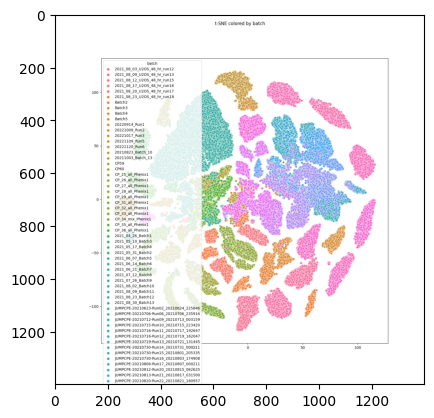

In [94]:
plt.imshow(plt.imread(os.path.join(plot_dir, "t-SNE_colored_by_batch.png")))

In [89]:
evaluator.embeddings_df["source"]

0     source_10
1     source_10
2     source_10
3     source_10
4     source_10
5     source_10
6     source_10
7     source_10
8     source_10
9     source_10
10    source_10
11    source_10
12    source_10
13    source_10
14    source_10
15    source_10
16    source_10
17    source_10
18    source_10
19    source_10
20    source_10
21    source_10
22    source_10
23    source_10
24    source_10
25    source_10
26    source_10
27    source_10
28    source_10
29    source_10
30    source_10
31    source_10
32    source_10
33    source_10
34    source_10
35    source_10
36    source_10
37    source_10
38    source_10
39    source_10
40    source_10
41    source_10
42    source_10
43    source_10
44    source_10
45    source_10
46    source_10
47    source_10
Name: source, dtype: object

In [59]:
evaluator.scorers["accuracy"]()

AttributeError: 'BatchEffectEvaluator' object has no attribute 'scorers'

In [32]:
cls = LogisticRegression(max_iter=1000)

In [60]:
cls, X_test, y_test = evaluator.fully_random(cls)

In [66]:
cls.predict(X_test)

array([5, 3, 2, 3, 3, 3, 2, 3, 3, 3])

In [76]:
labels = evaluator.label_encoder.classes_

In [77]:
y_test_str = evaluator.label_encoder.inverse_transform(y_test)
y_predict_str = evaluator.label_encoder.inverse_transform(cls.predict(X_test))
labels = evaluator.label_encoder.classes_

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

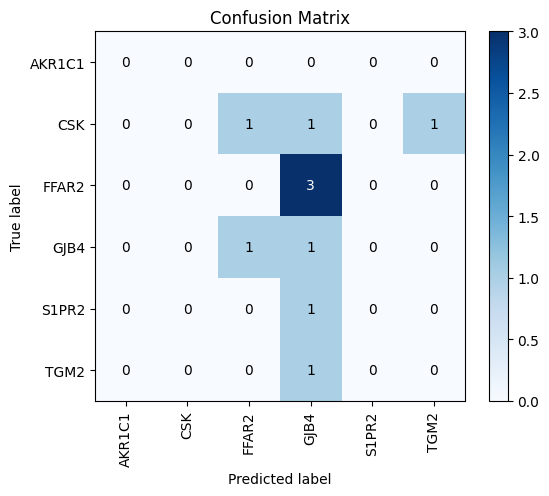

In [75]:
plot_confusion_matrix(y_test_str, y_predict_str, labels=labels, x_tick_rotation=90)

In [56]:
key = "top_3"
evaluator.scorers.keys()

dict_keys(['accuracy', 'balanced_accuracy', 'prec', 'recall', 'f1', 'roc_auc', 'top_3', 'top_5', 'top_10'])

In [55]:
evaluator.scorers[key](cls, X_test, y_test)

ValueError: Number of classes in 'y_true' (6) not equal to the number of classes in 'y_score' (2).You can provide a list of all known classes by assigning it to the `labels` parameter.

In [36]:
metric_dict = {k: scorer(cls, X_test, y_test) for k, scorer in evaluator.scorers.items()}

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AxisError: axis 1 is out of bounds for array of dimension 1

In [28]:
evaluator.run()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AxisError: axis 1 is out of bounds for array of dimension 1

In [21]:
tsne = PCA(n_components=2, random_state=0)
embeddings = tsne.fit_transform(np.array(evaluator.embeddings_df["embedding"].tolist()))

In [32]:
warnings.filterwarnings("ignore")

In [39]:
fig.canvas.draw()

In [43]:
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [45]:
buf = evaluator.plot_tsne(embeddings, "label", "PCA")

In [24]:
res = trainer.predict(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [51]:
def concat_from_list_of_dict(res, key):
    out = np.concatenate([r[key] for r in res])
    if out.ndim == 2:
        return out.tolist()
    else:
        return out
    # if isinstance(res[0][key], list):
    # elif isinstance(res[0][key], torch.Tensor):
    #     return np.concatenate([r[key] for r in res])

In [39]:
concat_from_list_of_dict(res, "label").shape

(8,)

In [37]:
concat_from_list_of_dict(res, "embedding").shape

(8, 512)

In [28]:
keys = list(res[0].keys())

In [29]:
keys

['label', 'batch', 'well', 'plate', 'embedding']

In [52]:
rr = {key: concat_from_list_of_dict(res, key) for key in keys}

In [56]:
embeddings_df = pd.DataFrame(rr)

In [57]:
embeddings_df

,label,batch,well,plate,embedding
0,47,2021_08_03_U2OS_48_hr_run12,A01,Dest210726-160150,"[0.07254214584827423, 0.009919458068907261, 0...."
1,47,2021_08_03_U2OS_48_hr_run12,A01,Dest210726-160150,"[0.1276015192270279, 0.0015592031413689256, 0...."
2,47,2021_08_03_U2OS_48_hr_run12,A01,Dest210726-160150,"[0.11575723439455032, 0.001082377857528627, 0...."
3,47,2021_08_03_U2OS_48_hr_run12,A01,Dest210726-160150,"[0.09687875211238861, 0.013040906749665737, 0...."
4,47,2021_08_03_U2OS_48_hr_run12,A01,Dest210726-160150,"[0.10322334617376328, 0.014591164886951447, 0...."
5,47,2021_08_03_U2OS_48_hr_run12,A01,Dest210726-160150,"[0.1038246750831604, 0.00964219868183136, 0.01..."
6,6,2021_08_03_U2OS_48_hr_run12,A04,Dest210726-160150,"[0.10418342053890228, 0.0007528336718678474, 0..."
7,6,2021_08_03_U2OS_48_hr_run12,A04,Dest210726-160150,"[0.042890824377536774, 0.006283625960350037, 0..."


## Module

## Evaluator